In [2]:
import tensorflow as tf
print('Tensorflow version: {}'.format(tf.__version__))

Tensorflow version: 2.2.0-rc4


In [0]:
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pathlib
import os

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

os.chdir("/content/gdrive/My Drive/Colab Notebooks/tensorflow")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
path_root = os.path.join(os.path.realpath("."),"DS","2_class")
data_dir = pathlib.Path(path_root)

In [6]:
#%%
#目录的数量
image_count = len(list(data_dir.glob('*/*.jpg')))
#显示类别
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*')])
print(CLASS_NAMES)

['lake' 'airplane']


In [7]:
#%%
# 打印该路径下的文件
for item in data_dir.iterdir():
    print(item)
import random  
all_image_path = list(data_dir.glob("*/*"))
all_image_path = [str(path) for path in all_image_path]
random.shuffle(all_image_path)

image_count = len(all_image_path)
print(image_count)

/content/gdrive/My Drive/Colab Notebooks/tensorflow/DS/2_class/lake
/content/gdrive/My Drive/Colab Notebooks/tensorflow/DS/2_class/airplane
1400


['/content/gdrive/My Drive/Colab Notebooks/tensorflow/DS/2_class/lake/lake_570.jpg', '/content/gdrive/My Drive/Colab Notebooks/tensorflow/DS/2_class/lake/lake_594.jpg', '/content/gdrive/My Drive/Colab Notebooks/tensorflow/DS/2_class/lake/lake_227.jpg', '/content/gdrive/My Drive/Colab Notebooks/tensorflow/DS/2_class/airplane/airplane_669.jpg', '/content/gdrive/My Drive/Colab Notebooks/tensorflow/DS/2_class/lake/lake_054.jpg', '/content/gdrive/My Drive/Colab Notebooks/tensorflow/DS/2_class/airplane/airplane_656.jpg', '/content/gdrive/My Drive/Colab Notebooks/tensorflow/DS/2_class/lake/lake_046.jpg', '/content/gdrive/My Drive/Colab Notebooks/tensorflow/DS/2_class/airplane/airplane_132.jpg', '/content/gdrive/My Drive/Colab Notebooks/tensorflow/DS/2_class/lake/lake_534.jpg', '/content/gdrive/My Drive/Colab Notebooks/tensorflow/DS/2_class/airplane/airplane_337.jpg']


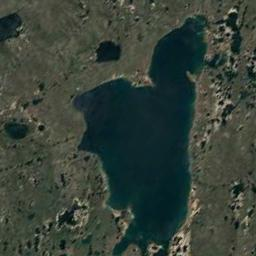

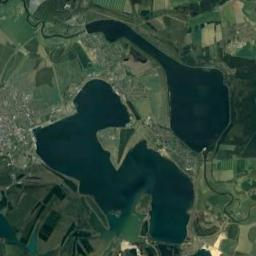

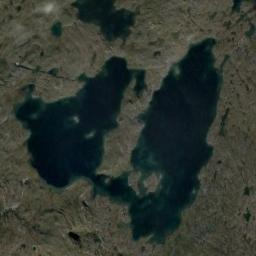

In [8]:
#%%
print(all_image_path[:10])
import IPython.display as display
for n in range(3):
  image_path = random.choice(all_image_path)
  display.display(display.Image(image_path))

In [9]:
#%%确定每个图像的标签
lable_names = sorted(item.name for item in data_dir.glob("*/"))
#为每个标签分配索引,构建字典
lable_to_index = dict((name,index) for index,name in enumerate(lable_names))
print(lable_to_index)
#创建一个列表，包含每个文件的标签索引
all_image_label = [lable_to_index[pathlib.Path(path).parent.name] for path in all_image_path]

{'airplane': 0, 'lake': 1}


In [10]:
#%%加载和格式化图片
#这里加载的是原始数据
img_raw = tf.io.read_file(all_image_path[0])
#将它解码为张量
img_tensor = tf.image.decode_image(img_raw)
print(img_tensor.shape,img_tensor.dtype)
#我们可以根据需要调整模型的大小
img_final = tf.image.resize(img_tensor,[192,192])
img_final = img_final/255.0
print(img_final.shape)
print(img_final.numpy().min())
print(img_final.numpy().max())

#包装为函数，以备后用
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256])
    image /= 255.0  # normalize to [0,1] range
    return image
#加载图片
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)


(256, 256, 3) <dtype: 'uint8'>
(192, 192, 3)
0.0
1.0


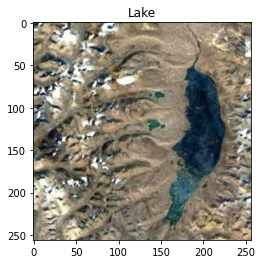

In [11]:
#%%
image_path = all_image_path[0]
label = all_image_label[0]

plt.imshow(load_and_preprocess_image(image_path))
plt.grid(False)
##plt.xlabel(caption_image(image_path))
plt.title(lable_names[label].title())
print()
    

<TensorSliceDataset shapes: (), types: tf.string>


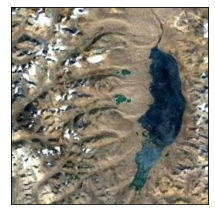

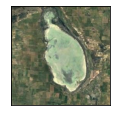

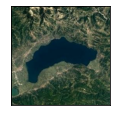

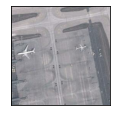

In [12]:
#%%构建一个tf.data.Dataset
#一个图片数据集构建 tf.data.Dataset 最简单的方法就是使用 from_tensor_slices 方法。
#将字符串数组切片，得到一个字符串数据集：
path_ds =  tf.data.Dataset.from_tensor_slices(all_image_path)
print(path_ds)
#现在创建一个新的数据集，通过在路径数据集上映射 preprocess_image 来动态加载和格式化图片。
AUTOTUNE = tf.data.experimental.AUTOTUNE
image_ds = path_ds.map(load_and_preprocess_image,num_parallel_calls=AUTOTUNE)

plt.figure(figsize=(8,8))
for n, image in enumerate(image_ds.take(4)):
    plt.subplot(2,2,n+1)
    plt.imshow(image)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
  #plt.xlabel(caption_image(all_image_path[n]))
    plt.show()


In [13]:
#%%一个（图片，标签）对数据集
lable_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_label,tf.int64))
for label in lable_ds.take(5):
    #print(label)
    print(lable_names[label.numpy()])
#因为这些数据集顺序相同，可以将他们打包起来
image_label_ds = tf.data.Dataset.zip((image_ds,lable_ds))
print(image_label_ds)
#注意：当你拥有形似 all_image_labels 和 all_image_paths 的数组，tf.data.dataset.Dataset.zip 的替代方法是将这对数组切片
# =================================im============================================
# ds = tf.data.Dataset.from_tensor_slices((all_image_path,all_image_label))
# def load_and_preprocess_from_path_label(path, label):  
#     return load_and_preprocess_image(path),label
# image_label_ds = ds.map(load_and_preprocess_from_path_label)    
# =============================================================================

lake
lake
lake
airplane
lake
<ZipDataset shapes: ((256, 256, 3), ()), types: (tf.float32, tf.int64)>


In [14]:
#%%设置训练数据和测试数据的大小

test_count = int(image_count*0.2)
train_count = image_count - test_count
print(test_count,train_count)
#跳过test_count个
train_dataset = image_label_ds.skip(test_count)
test_dataset = image_label_ds.take(test_count)

280 1120


In [0]:
#%%开始训练
'''
训练我们会将数据
1.充分的打乱
2.被分割batch'
3.永远的重复
4.尽快的batch
'''
batch_size = 32
# 设置一个和数据集大小一致的 shuffle buffer size（随机缓冲区大小）以保证数据被充分打乱。
train_ds = train_dataset.shuffle(buffer_size=image_count).repeat().batch(batch_size)
test_ds = test_dataset.batch(batch_size)
# # 当模型在训练的时候，`prefetch` 使数据集在后台取得 batch。
# ds = ds.prefetch(buffer_size=AUTOTUNE)

In [0]:
#%%数据标准化
model = tf.keras.Sequential()   #顺序模型
model.add(tf.keras.layers.Conv2D(64, (3, 3), input_shape=(256, 256, 3), activation='relu'))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu'))
model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Conv2D(512, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(512, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Conv2D(1024, (3, 3), activation='relu'))
model.add(tf.keras.layers.GlobalAveragePooling2D())

model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [17]:
#%%
model.summary()
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc']
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 252, 252, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 122, 122, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 61, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 59, 59, 256)       2

In [18]:
#%%
steps_per_eooch = train_count//batch_size
validation_steps = test_count//batch_size

history = model.fit(train_ds,epochs=30,steps_per_epoch=steps_per_eooch,validation_data=test_ds,validation_steps=validation_steps)

Epoch 1/30
35/35 [==============================] - 20s 565ms/step - loss: 0.8902 - acc: 0.5688 - val_loss: 0.4821 - val_acc: 0.8672
Epoch 2/30
35/35 [==============================] - 19s 556ms/step - loss: 0.7571 - acc: 0.6170 - val_loss: 0.6877 - val_acc: 0.5078
Epoch 3/30
35/35 [==============================] - 19s 556ms/step - loss: 0.6371 - acc: 0.6232 - val_loss: 0.4861 - val_acc: 0.8008
Epoch 4/30
35/35 [==============================] - 19s 555ms/step - loss: 0.4127 - acc: 0.8554 - val_loss: 0.2898 - val_acc: 0.9062
Epoch 5/30
35/35 [==============================] - 19s 557ms/step - loss: 0.4168 - acc: 0.7688 - val_loss: 0.4776 - val_acc: 0.5000
Epoch 6/30
35/35 [==============================] - 19s 555ms/step - loss: 0.4127 - acc: 0.7080 - val_loss: 0.2026 - val_acc: 0.9297
Epoch 7/30
35/35 [==============================] - 19s 556ms/step - loss: 0.2303 - acc: 0.9384 - val_loss: 0.1515 - val_acc: 0.9453
Epoch 8/30
35/35 [==============================] - 19s 556ms/step - 

In [20]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

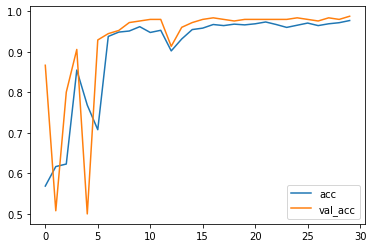

In [21]:
plt.plot(history.epoch, history.history.get('acc'), label='acc')
plt.plot(history.epoch, history.history.get('val_acc'), label='val_acc')
plt.legend()

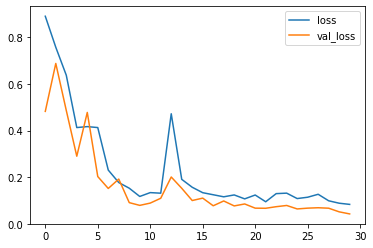

In [22]:
plt.plot(history.epoch, history.history.get('loss'), label='loss')
plt.plot(history.epoch, history.history.get('val_loss'), label='val_loss')
plt.legend()